# BigDL object detection demo

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Disable auto scroll

In [2]:
from utils import *
init()
%matplotlib inline

Verify and read some environment information (e.g. executor number and executor core number)

Convert image data to RDD

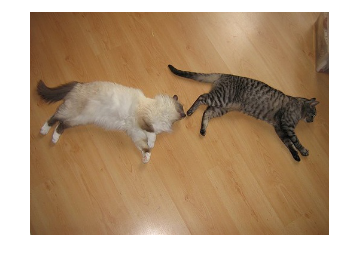

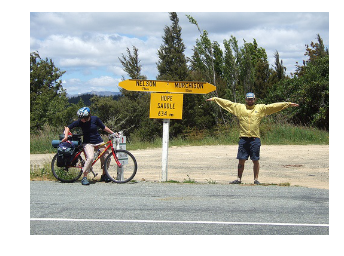

In [3]:
ssd_home = "../../pipeline/ssd/"
# load and show images
folder = ssd_home + "data/pascal/images"
images = load_local_folder(folder)
show_images(images)

img_rdd = sc.parallelize(images)

Download and load pretrained BigDL model

SSD with mobilenet: https://s3-ap-southeast-1.amazonaws.com/bigdl-models/ssd/bigdl_ssd_mobilenet_300x300_voc.model

In [4]:
# load object class names
classes = load_pascal_classes()

## Run image detection and visualization
Having prepared the model and data, we can start detecting objects. We’ll first preprocess the raw image rdd, including resize, means substraction, scale. Then detection model is applied to the processed data to do the detection. The model output is then scaled back according to original image sizes. In the end, we visualize the detections in original images.

load model done
creating: createResize
creating: createChannelNormalize
creating: createMatToFloats
creating: createImageFrame


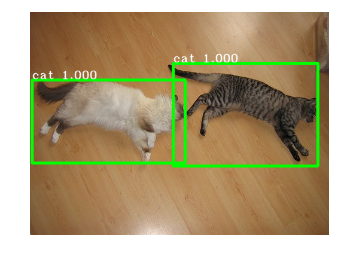

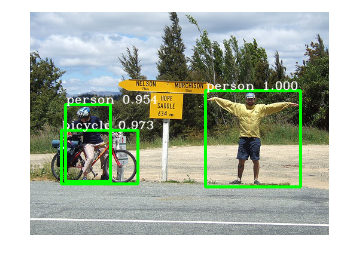

In [5]:
# load model
model = Model.loadModel(ssd_home + "data/models/bigdl_ssd_mobilenet_300x300_voc.model")
print 'load model done'

images = load_local_folder(folder)

img_rdd = sc.parallelize(images)

# preprocess data
data = preprocess_ssd_mobilenet(img_rdd)

# image prediction
output = object_detect(model, data)

detections = output.collect()

visualize_detections(images, detections, classes)

show_images(images)
    

creating: createResize
creating: createChannelNormalize
creating: createMatToFloats
creating: createImageFrame


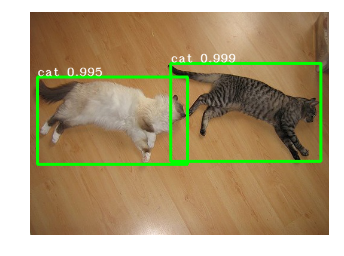

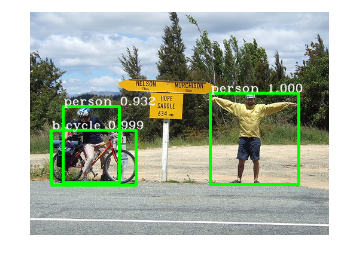

In [6]:
images = load_local_folder(folder)
img_rdd = sc.parallelize(images)

model = Model.loadModel(ssd_home + "data/models/bigdl_ssd_vgg_300x300_voc.model")

# load object class names
classes = load_pascal_classes()

# preprocess data
data = preprocess_ssd_vgg(img_rdd)

# image prediction
output = object_detect(model, data)

detections = output.collect()

visualize_detections(images, detections, classes)

show_images(images)

creating: createAspectScale
creating: createChannelNormalize
creating: createMatToFloats
creating: createImageFrame


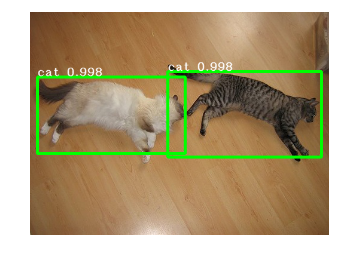

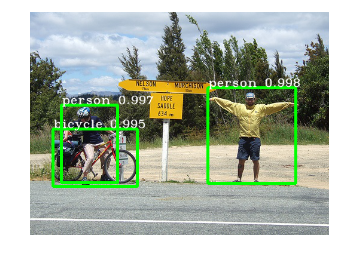

In [7]:
images = load_local_folder(folder)
img_rdd = sc.parallelize(images)

# preprocess data
data = preprocess_frcnn_vgg(img_rdd)

model = Model.loadModel(ssd_home + "data/models/bigdl_frcnn_vgg_voc.model")

# load object class names
classes = load_pascal_classes()


# image prediction
output = object_detect(model, data)

detections = output.collect()

visualize_detections(images, detections, classes)

show_images(images)

creating: createAspectScale
creating: createChannelNormalize
creating: createMatToFloats
creating: createImageFrame
load model done ...


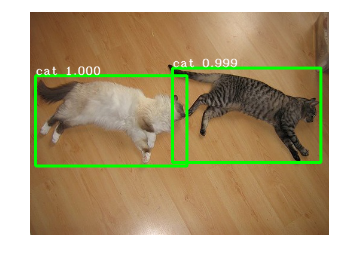

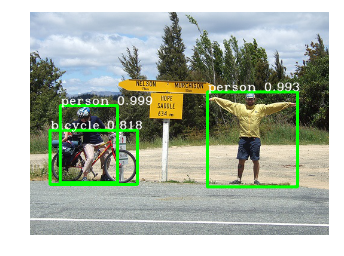

In [8]:
images = load_local_folder(folder)
img_rdd = sc.parallelize(images)

# preprocess data
data = preprocess_frcnn_pvanet(img_rdd, n_partition=2)

model = Model.loadModel(ssd_home + "data/models/bigdl_frcnn_pvanet_voc.model")
print 'load model done ...'
# load object class names
classes = load_pascal_classes()

# image prediction
output = object_detect(model, data)

detections = output.collect()

visualize_detections(images, detections, classes)

show_images(images)

## Video detection

Next we will play with some videos. To achieve this, I adopt moviepy for video read/write.

The detection steps are similar to the above image detection.
* Read video with VideoFileClip, and for demo simplicity, I extract the first 10 seconds of videos with 5 fps. Then convert the frames to spark RDD and preprocess the RDD.
* Apply BigDL model to do the object detection.
* Save the detected frames back to video with ImageSequenceClip.

In [9]:
# load model
model = Model.loadModel(ssd_home + "data/models/bigdl_ssd_mobilenet_300x300_voc.model")
print 'load model done'

# load object class names
classes = load_pascal_classes()

from moviepy.editor import *
myclip = VideoFileClip("/home/jxy/Downloads/Dog imitates baby.mp4").subclip(139,149)

video_rdd = sc.parallelize(myclip.iter_frames(fps=5))
data = preprocess_ssd_mobilenet(video_rdd)

output = object_detect(model, data)

image_detection = video_rdd.zip(output).map(lambda (data, result): visualize(data, result, classes, 0.3))
results = image_detection.collect()
results = filter(lambda x: x!=None, results)

load model done
creating: createResize
creating: createChannelNormalize
creating: createMatToFloats
creating: createImageFrame


In [10]:
import io
import base64
from IPython.display import HTML

clip = ImageSequenceClip(results, fps=5)

output_path = '/tmp/out.mp4'
%time clip.write_videofile(output_path, audio=False)


video = io.open(output_path, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test"  width="600"controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


[MoviePy] >>>> Building video /tmp/out.mp4
[MoviePy] Writing video /tmp/out.mp4


100%|██████████| 50/50 [00:00<00:00, 99.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /tmp/out.mp4 

CPU times: user 40 ms, sys: 52 ms, total: 92 ms
Wall time: 1.68 s


In [14]:
from moviepy.editor import *
clip = VideoFileClip("/tmp/out.mp4")
clip.write_gif("final.gif")


[MoviePy] Building file final.gif with imageio


 98%|█████████▊| 50/51 [00:09<00:00,  4.23it/s]


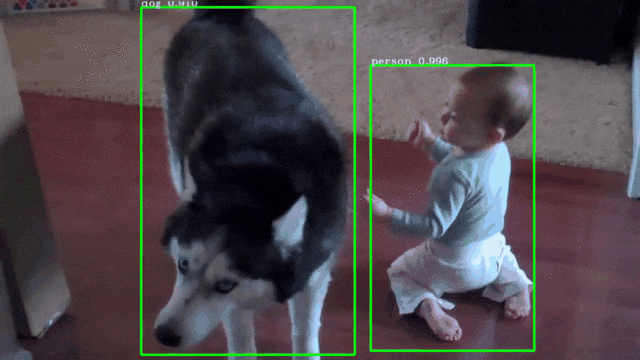

In [16]:
from IPython.display import Image
from IPython.display import display
with open("final.gif",'rb') as f:
    display(Image(f.read()), format='png')